# Analiza danych multimedialnych projekt

### Autorzy: Kamil Sakowicz, Kacper Majkowski



## Opis projektu

Celem projektu było stworzenie modelu, który będzie umieć rozpoznawać przedmioty na obrazach.

Do szkolenia modelu został wykorzystany zbiór danych CIFAR-10. Zbiór ten zawiera 60000 kolorowych obrazów o wymiarach 32x32, zbiór treningowy zawiera 50000 obrazów, a zbiór testowy 10000. W zbiorze tym wydzielonych jest 10 rozłącznych grup przedmiotów, takich jak: samolot, samochód, ptak, kot, jeleń, pies, żaba, koń, statek, ciężarówka. Każda klasa zawiera 6000 zdjęć, a na każdym zdjęciu znajduje się tylko jeden przedmiot reprezentujący tę klasę.

Model zaimplementowaliśmy przy zastosowaniu konwolucyjnych sieci neuronowych, które są bardzo skuteczne w rozpoznawaniu obrazów.

Jako ostatni etap projektu, chcieliśmy sprawdzić skuteczność tego modelu na innych zbiorach obrazów, aby ocenić jego faktyczną skuteczność i przydatność


#### Wczytanie bibliotek

In [6]:
import os

import numpy as np
from keras import Sequential
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.src.layers import Conv2D, BatchNormalization, Dense, Flatten, MaxPooling2D, Dropout
from keras.src.optimizers import Adam
from keras.src.regularizers import L2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import  tensorflow as tf

In [4]:
def show_picture(picture):
    plt.imshow(picture)
    plt.show()

def convert_to_hot_one(y_tr, y_valid, y_tst):
    y_tr = tf.keras.utils.to_categorical(y_tr, 10)
    y_valid = tf.keras.utils.to_categorical(y_valid, 10)
    y_tst = tf.keras.utils.to_categorical(y_tst, 10)
    return y_tr, y_valid, y_tst

#### Wczytanie danych ze zbioru

In [5]:
(x_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
X_train, X_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

#### Sprawdzenie wymiarów danych

In [4]:
print('Train images: ', X_train.shape)
print('Train labels: ', y_train.shape)

print('Validation images: ', X_valid.shape)
print('Validation labels: ', y_valid.shape)

print('Test images: ', X_test.shape)
print('Test labels: ', y_test.shape)

Train images:  (45000, 32, 32, 3)
Train labels:  (45000, 1)
Validation images:  (5000, 32, 32, 3)
Validation labels:  (5000, 1)
Test images:  (10000, 32, 32, 3)
Test labels:  (10000, 1)


#### Standaryzacja danych oraz przekształcenie etykiet za pomocą hot-one

Ustawiamy typ wartości na float, następnie normalizujemy wartości, aby były one w tej samej skali. Sieci neurowe są wrażliwe na skale danych wejściowych, więc dzięki normalizacji temu model będzie się lepiej uczył.

In [5]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

mean = np.mean(X_train)
std  = np.std(X_train)

X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

y_train, y_valid, y_tst = convert_to_hot_one(y_train, y_valid, y_test)

#### Tworzenie modelu

Model został zrobiony w następujący sposób: 2 warstwy konwolucyjne, po każdej z nich warstwa normalizująca, następnie warstwa MaxPooling oraz Dropout, aby zmniejszyć ilość aktywnych neuronów.

Schemat ten powtarza się 2 razy, w drugim powtórzeniu zwiększamy ilość filtrów warstw konwolucyjnych dwukrotnie, oraz zwiększamy dropout rate o 0.1.

Po drugim powtórzeniu stosujemy warstwę flatten oraz dense, aby uzyskać wyniki w postaci wektora odpowiadającemu prawdopodobieństwa przynależności do jednej z 10 klas.

In [6]:
model = Sequential()
weight_decay = 0.0001

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=L2(weight_decay), input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=L2(weight_decay), input_shape=X_train.shape[1:]))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=L2(weight_decay), input_shape=X_train.shape[1:]))   
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=L2(weight_decay), input_shape=X_train.shape[1:]))   
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

C:\Users\kamil\PycharmProjects\ADM_Projekt\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,306 (419.16 KB)

 Trainable params: 106,922 (417.66 KB)

 Non-trainable params: 384 (1.50 KB)

#### Trenowanie modelu

Jako optymalizator został wykorzystany Adam, jako funkcje straty użyliśmy entropii krzyżowej dla wielu klas.

Ponadto, do trenowania tego modelu dodaliśmy funkcje ReduceLROnPlateau do zwiększenia dokładności modelu, oraz funkcję EarlyStopping, która zatrzyma uczenie, jeśli model nie poprawia się przez określony czas.

In [8]:
batch_size = 64
epochs = 100
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

model.fit(X_train, y_train, batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[reduce_lr, early_stopping], 
          verbose=2)

Epoch 1/100
704/704 - 36s - 51ms/step - accuracy: 0.3373 - loss: 2.2705 - val_accuracy: 0.4704 - val_loss: 1.5328 - learning_rate: 1.0000e-04
Epoch 2/100
704/704 - 34s - 48ms/step - accuracy: 0.4529 - loss: 1.6769 - val_accuracy: 0.5364 - val_loss: 1.3215 - learning_rate: 1.0000e-04
Epoch 3/100
704/704 - 34s - 49ms/step - accuracy: 0.5083 - loss: 1.4652 - val_accuracy: 0.5640 - val_loss: 1.2359 - learning_rate: 1.0000e-04
Epoch 4/100
704/704 - 34s - 49ms/step - accuracy: 0.5513 - loss: 1.3315 - val_accuracy: 0.5986 - val_loss: 1.1452 - learning_rate: 1.0000e-04
Epoch 5/100
704/704 - 34s - 49ms/step - accuracy: 0.5868 - loss: 1.2234 - val_accuracy: 0.6294 - val_loss: 1.0710 - learning_rate: 1.0000e-04
Epoch 6/100
704/704 - 35s - 50ms/step - accuracy: 0.6122 - loss: 1.1379 - val_accuracy: 0.6448 - val_loss: 1.0108 - learning_rate: 1.0000e-04
Epoch 7/100
704/704 - 35s - 50ms/step - accuracy: 0.6403 - loss: 1.0576 - val_accuracy: 0.6604 - val_loss: 0.9841 - learning_rate: 1.0000e-04
Epoch 

#### Testowanie modelu

Model dla danych testowych osiągnął dokładność 0.789, co jest całkiem dobrym wynikiem. Można ten model poprawić poprzez dodanie kolejnych warstw, jednak uznaliśmy, że na potrzeby tego projektu wynik jest zadowalający.

In [12]:
model = tf.keras.models.load_model('first_model.keras')
test_loss, test_acc = model.evaluate(X_test, y_tst, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

C:\Users\Kacper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7937 - loss: 0.6785

Test Accuracy: 0.7896000146865845
Test Loss:     0.6862348914146423


In [13]:
model.save('first_model.keras')

#### Sprawdzenie modelu dla innych zbiorów danych

In [13]:
import cv2
import numpy as np

model = tf.keras.models.load_model('first_model.keras')

def test_accuracy_on_dataset(directory, target_result_index):
    X = np.ndarray(shape=(0, 32, 32, 3), dtype=np.float32)

    for foldername in os.listdir(directory):
        directory2 = os.path.join(directory, foldername)
        for filename in os.listdir(directory2):
            if filename.endswith('.jpg'):
                f = os.path.join(directory2, filename)
                img = cv2.imread(f)
                img = cv2.resize(img, (32, 32))
                X = np.append(X, [img], axis=0)
        results = model.predict(X)

        total = 0
        correct = 0
        for r in results:
            arg = np.argmax(r)
            if arg == target_result_index:
                correct += 1
            total += 1

        print(foldername + ' accuracy:', correct / total)

C:\Users\Kacper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Wyniki i wnioski

Wyniki modelu dla innych zbiorów danych są słabe. Może to być spowodowane specyfiką nowych danych, na których np. może się znajdować parę obiektów danej klasy, na co model nie jest przygotowany. Mogą się również w nich znajdować obiekty innych klas lub obiekty, które nie są przypisane do żadnej klasy, co również może powodować słabe działanie tego modelu

In [10]:
test_accuracy_on_dataset('Cars Dataset/test', 1) # Średnia dokładność ~35%
test_accuracy_on_dataset('dogs/data/test', 5) # ~9%
test_accuracy_on_dataset('cats', 3) # ~12%

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
animal animal_faces dog dog_face accuracy: 0.08506616257088846
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
animal dog accuracy: 0.08415841584158416
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
animal dog afghan accuracy: 0.08589951377633712
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
animal dog african_wild_dog accuracy: 0.083596214511041
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
animal dog airedale accuracy: 0.08385093167701864
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
animal dog american_bulldog accuracy: 0.08497723823975721


In [35]:
from sklearn import metrics
import numpy as np
import cv2

def create_confusion_matrix(directory, target_index):

    X = np.ndarray(shape=(0, 32, 32, 3), dtype=np.float32)
    y = np.array([])
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            f = os.path.join(directory, filename)
            img = cv2.imread(f)
            img = cv2.resize(img, (32, 32))
            X = np.append(X, [img], axis=0)
            y = np.append(y, [target_index], axis=0)
    results = model.predict(X)
    results = np.argmax(results, axis=1)
    print(results)
    print(y)
    all_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    confusion_matrix = metrics.confusion_matrix(y, results, labels=all_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = all_labels)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title('CM: ' + directory)
    plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[1 1 1 0 9 0 0 1 1 1 0 0 7 0 1 7 0 0 1 3 9 0 7 9 8 0 7 1 1 1 7 0 0 0 9 7 0
 1 3 7 1 0 0 1 1 1 0 1 7 0 1 0 7 0 4 1 9 4 9 1 7 9 7 9 1 1 1 1 7 0 1 7 7 8
 1 1 7 7 7 1 9 1 1 0 1 8 7 0 7 1 1 9 1 0 1 1 1 1 1 1 1 1 7 1 1 0 1 0 0 9 1
 1 1 1 1 1 9 1 1 1 9 7 0 0 4 1 0 9 0 9 1 1 3 0 1 7 7 8 1 0 0 4 3 0 0 7 1 1
 7 0 1 0 0 9 9 8 9 0 7 1 9 1 1 0 7 1 1 0 8 7 0 2 7 0 0 7 3 9 0 9 1 0 9 7 0
 1 7 9 1 0 1 0 1 1 7 0 3 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

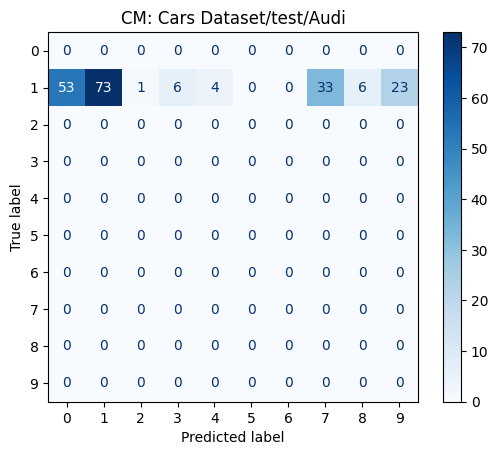

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[1 9 9 8 3 7 0 7 7 0 7 3 3 7 8 0 0 8 8 7 1 9 8 7 7 4 9 1 7 9 7 7 7 7 3 7 8
 8 7 0 7 7 1 0 9 0 0 0 0 3 9 7 0 3 7 0 3 0 0 1 8 8 0 4 9 1 9 7 3 9 0 7 8 7
 7 4 9 7 3 7 0 0 0]
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


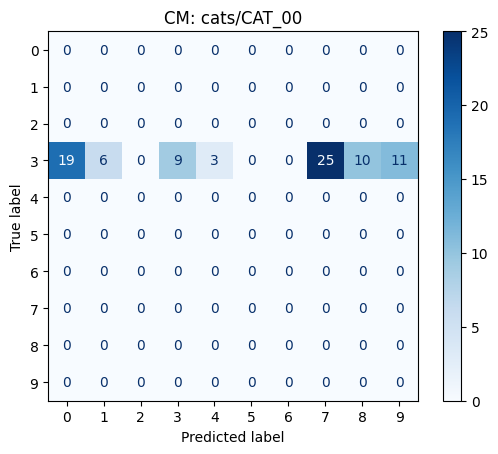

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[7 5 2 7 2 0 8 5 5 2 8 3 7 3 3 9 7 5 7 9 7 7 7 7 0 0 8 7 8 8 7 7 8 7 7 5 9
 0 8 8 9 7 3 7 7 3 8 7 0 7 7 8 8 7 5 3 3 3 7 8 8 9 8 3 7 3 9 7 3 3 7 3 7 1
 7 7 3]
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5.]


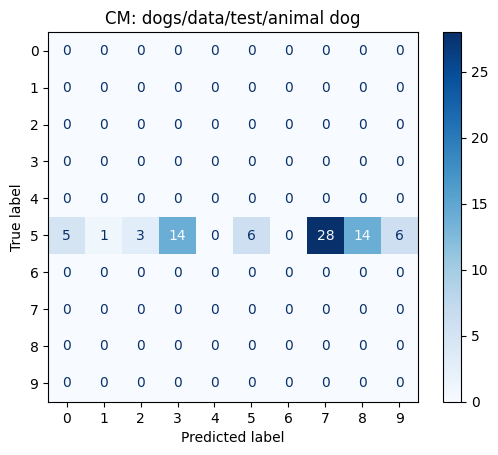

In [37]:
create_confusion_matrix('Cars Dataset/test/Audi', 1)
create_confusion_matrix('cats/CAT_00', 3)
create_confusion_matrix('dogs/data/test/animal dog', 5)
# 0:airplane 1:automobile 2:bird 3:cat 4:deer 5:dog 6:frog 7:horse 8:ship 9:truck